In [168]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
from os import listdir
from os.path import isfile, join
import skfda
from skfda.representation.interpolation import SplineInterpolation
from skfda.exploratory.visualization import Boxplot
import datetime as dt
from numpy.polynomial.polynomial import polyfit
from sklearn.metrics import mean_squared_error
from random import *
from scipy.signal import argrelextrema

In [169]:
# Variabili globali

path = 'pala_ok/fullDischargeGoodmotor/'

In [170]:
allNI = []

allRPM = []

all_Volts = []

# Andiamo a prendere tutti i path dei vari file

path_acquisizioni = [f for f in listdir(path) if isfile(join(path, f))]

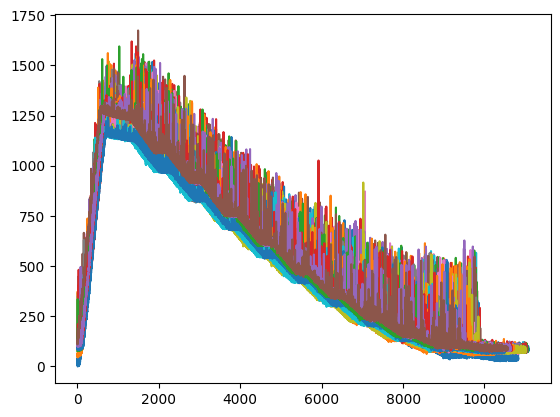

In [171]:
for a in path_acquisizioni:
    if("NI" in a):
        try:
            allNI.append(pd.read_csv(path+a,sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))
        except:
            df = pd.read_csv(path+a,sep='\t').drop_duplicates(subset=['Time'],keep='last',ignore_index=True)
            allNI.append(df.rename(columns={"Time": "time"}))
            
    if("RPM" in a):
        allRPM.append(pd.read_csv(path+a,sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))
    if("Volts" in a):
        all_Volts.append(pd.read_csv(path+a,sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))

allacqui = []
for a,b in zip(allNI,range(len(allNI))):
    allacqui.append([])
    a['Voltage'] = (10 - a['Voltage'])*500
    plt.plot(a['Voltage'])
    allacqui[-1].append(a)

In [172]:
print(len(allNI))
print(len(all_Volts))
print(len(allRPM))

46
46
46


In [173]:
print(randint(1,10))

df = pd.DataFrame(
	[[88, 72, 67],
	[23, 78, 62],
	[55, 54, 76]],
	columns=['a', 'b', 'c'])

index = max(df.index.to_list())
print(np.mean([df.loc[1+1]['a'],5]))
print(df.columns.values[0])

2
30.0
a


In [174]:
def getPWM(DataFrameRPM):
    #Get PWN of RPM/Battery
    DataFrameMean = DataFrameRPM['rpm'].rolling(150,min_periods = 1,center=False).mean()
    gradient = np.gradient(DataFrameMean,np.arange(DataFrameMean.shape[0]))
    rollmax = np.array(pd.DataFrame(gradient).rolling(150,min_periods = 1,center=False).max())[:,0]
    rollmaxDataframe = pd.DataFrame(rollmax)
    ilocs_min = argrelextrema(rollmax, np.less_equal, order=10)[0]
    ilocs_max = argrelextrema(rollmax, np.greater_equal, order=10)[0]
    Minindexes = rollmaxDataframe.iloc[ilocs_min].nsmallest(10,0, keep='first').index.sort_values()
    def genpwm(x):
        res = 100
        for i in Minindexes:
            if x>i:
                res = res-10
        return res
    ranges = DataFrameRPM.index
    maxindex = rollmaxDataframe.iloc[ilocs_max].nlargest(1,0, keep='first')
    print(maxindex.index[0])
    pwmRPM = list(map(genpwm,list(ranges)))
    pwmRPM[:maxindex.index[0]] = [0] * (maxindex.index[0])
    
    ##Get PWN of NationalInstrument
    #timestamps = DataFrameRPM.iloc[Minindexes].time
    #
    #def genpwmNI(x):
    #    res = 100
    #    for i in timestamps:
    #        if x>i:
    #            res = res-10
    #    return res
    #pwmNI = []
    #maxtime = DataFrameRPM.iloc[maxindex.index[0]].time
    #maxtimeindex = DataframeNI[DataframeNI['time'] == list(filter(lambda i: i > maxtime, DataframeNI['time']))[0]].index[0]
    #pwmNI = list(map(genpwmNI,list(DataframeNI.time)))
    #pwmNI[:maxtimeindex] = [0] * (len(pwmNI) - maxtimeindex)
    
    return pwmRPM
    

In [175]:
def data_augmentation(df:pd.DataFrame,dimension:int):

    difference = dimension-df.shape[0]
    
    for a in range(difference):

        time = df.columns.values[0]

        value = df.columns.values[1]

        random_value = randint(min(df.index.to_list())+1,max(df.index.to_list())-1)
 
        new_value = (df.loc[random_value][value]+df.loc[random_value+1][value])/2

        new_timestamp = df.loc[random_value][time] + 1000
        
        new_row = pd.DataFrame({time:new_timestamp, value:new_value}, index=[random_value])

            
        df = pd.concat([df.iloc[:random_value], new_row, df.iloc[random_value:]]).reset_index(drop=True)

    return df
        


In [176]:
max_list = []

for a in allNI:
    max_list.append(a.shape[0])

print(max(max_list))

for a in allNI[0]['Voltage']:
    print(a)

11077
9.90974968590308
9.90974968590308
27.033333244617097
41.57222494541202
5.548082175664604
16.856109054059765
10.071292927023023
4.094193005585112
6.032711899024434
-1.2367339513730258
13.948330713901669
13.625244231661782
4.740365970064886
5.709625416783659
3.932649764465168
9.10203348030425
6.032711899024434
10.717465891502798
10.232836168142967
4.578822728944942
5.871168657903603
6.194255140144378
7.486601069103926
10.071292927023023
5.38653893454466
7.001971345744096
6.517341622384265
16.533022571820766
10.879009132621853
11.848268579342403
4.255736246705055
8.61740375694442
41.24913846317213
3.4480200411053374
115.39748613722622
29.133395379176363
6.517341622384265
5.709625416783659
4.9019092111848295
10.717465891502798
4.578822728944942
1.8325876299059018
10.232836168142967
55.30340044060722
5.871168657903603
22.99475221661762
9.10203348030425
18.47154146526009
10.717465891502798
11.20209561486174
13.786787472781725
22.025492769898847
13.625244231661782
13.786787472781725
19.

In [177]:
test1 = data_augmentation(allNI[0],11077)
test2 = data_augmentation(allRPM[0],11077)
print(test2.shape)

(11077, 2)


In [178]:
# Andiamo a lavorare sui dati di national instrument, ne riduciamo le dimensioni usando la media

data_matrix = test1['Voltage']
grid_points = test2['rpm']

fd_manu = skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points=grid_points,
    dataset_name="Datagrid di esempio",
    argument_names=('time',),
    coordinate_names=('values',),
    interpolation=SplineInterpolation(interpolation_order=1)
)
    

In [179]:
allPWM = []

for ni,rpm,volt,indice in zip(allNI,allRPM,all_Volts,range(len(allNI))):
    dim = min([len(ni.index),len(rpm.index),len(volt.index)])
    
    '''allNI[indice] = data_augmentation(ni,dim)
    allRPM[indice] = data_augmentation(rpm,dim)
    all_Volts[indice] = data_augmentation(volt,dim)'''

    new_rpm = rpm.sample(dim).sort_values(by=['time'])

    allNI[indice] = ni.sample(dim).sort_values(by=['time'])
    allRPM[indice] = new_rpm
    all_Volts[indice] = volt.sample(dim).sort_values(by=['time'])
    allPWM.append(
        pd.DataFrame(getPWM(new_rpm), columns=['pwm'])
        )




163
67
63
69
75
66
70
59
65
190
66
82
64
69
88
63
71
61
65
87
71
77
62
70
58
64
70
66
63
59
65
64
60
64
67
67
63
78
77
65
91
59
99
64
61
67


In [180]:
for a in range(len(allPWM)):
    allPWM[a].replace(to_replace=np.NaN, value=0,inplace = True)
print(allPWM[1]['pwm'])

0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
30         0
31         0
32         0
33         0
34         0
35         0
36         0
37         0
38         0
39         0
40         0
41         0
42         0
43         0
44         0
45         0
46         0
47         0
48         0
49         0
50         0
51         0
52         0
53         0
54         0
55         0
56         0
57         0
58         0
59         0
60         0
61         0
62         0
63         0
64         0
65         0
66         0
67       100
68       100
69       100
70       100
71       100
72       100
73       100
74       100
75       100
76       100

In [181]:
for a in range(len(allRPM)):
    allRPM[a]['pwm'] = allPWM[a]

In [182]:
print(len(allNI[0]))
print(len(all_Volts[0]))
print(len(allRPM[0]))

pd.set_option('display.max_rows', allRPM[0].shape[0]+1)
print(allRPM[1])

10582
10582
10582
                   time   rpm    pwm
0      1684761612238532     0    0.0
1      1684761612239532     0    0.0
2      1684761612240534     0    0.0
3      1684761612241532     0    0.0
4      1684761612242531     0    0.0
5      1684761612243792     0    0.0
6      1684761612244800     0    0.0
7      1684761612245835     0    0.0
8      1684761612246834     0    0.0
9      1684761612247833     0    0.0
10     1684761612248838     0    0.0
11     1684761612249800     0    0.0
12     1684761612250800     0    0.0
13     1684761612251800     0    0.0
14     1684761612252802     0    0.0
15     1684761612253842     0    0.0
16     1684761612254841     0    0.0
17     1684761612255844     0    0.0
18     1684761612256826     0    0.0
19     1684761612257844     0    0.0
20     1684761612258800     0    0.0
21     1684761612259804     0    0.0
22     1684761612260846     0    0.0
23     1684761612261841     0    0.0
24     1684761612262842     0    0.0
25     1684761612263

In [183]:
# Andiamo a definire un datagrid per ogni dataframe con NUOVE SPECIFICHE

all_data_grid = []

for ni,rpm in zip(allNI,allRPM):
        
    data_matrix = np.array(ni[ni.columns.values[1]]),
    grid_points = np.array(rpm[rpm.columns.values[1]])

    all_data_grid.append(skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points=grid_points,
    dataset_name='pippo',
    argument_names=(ni.columns.values[1],),
    coordinate_names=(rpm.columns.values[1],),
    interpolation=SplineInterpolation(interpolation_order=1)
        ))

c:\Users\pc\anaconda3\envs\manutenzione\lib\site-packages\skfda\exploratory\depth\multivariate.py:276: RuntimeWarning: invalid value encountered in divide
  return (  # type: ignore[no-any-return]


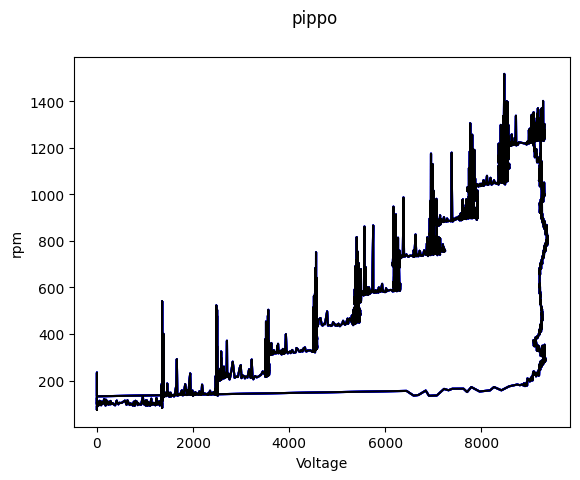

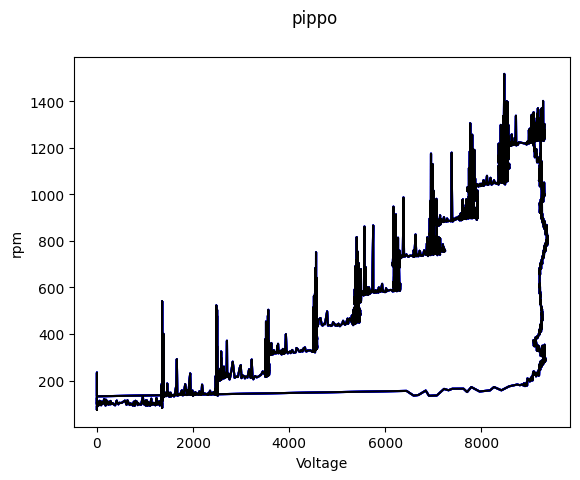

In [184]:
fdBoxplot = Boxplot(all_data_grid[2])
fdBoxplot.show_full_outliers = True
fdBoxplot.plot()

In [185]:
#Fitting for National Instrument
pol_maxGrade = 4 # afte the grade 5 it become glitchy
fit_result = []
for acquisizione in all_data_grid:
    fit_result.append([])
    for dataset in acquisizione:

        fit_result[-1].append([])
        for i in range(pol_maxGrade):
            fit_result[-1][-1].append(polyfit(dataset.data_matrix[1][:,0],dataset.data_matrix[0],deg=i+1))

IndexError: index 1 is out of bounds for axis 0 with size 1

NameError: name 'pwm_min' is not defined

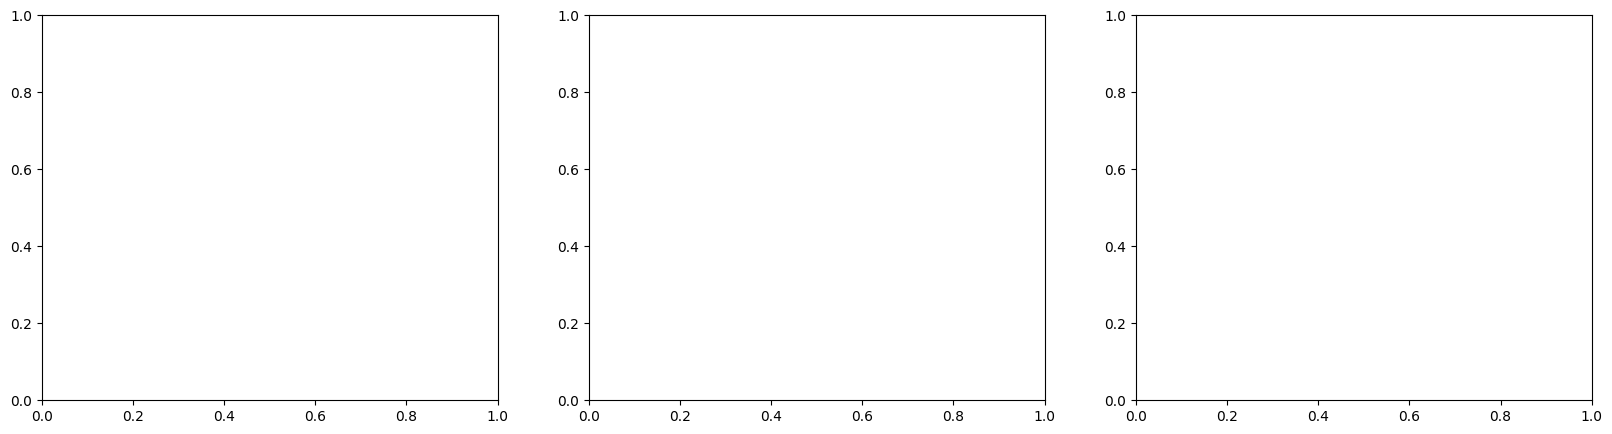

In [ ]:

for acquisizione,fit_set in zip(all_data_grid,fit_result):
    fig, axs = plt.subplots(nrows = 1, ncols = 3)
    fig.set_size_inches(h=5,w=20)
    
    linex = np.arange(pwm_min,pwm_max,1,dtype='longdouble')
    
    for dataset,dataset_fit,index in zip(acquisizione,fit_set,range(len(acquisizione))):
        axs[index].plot(dataset.data_matrix[1][:,0],dataset.data_matrix[0],'.')
        axs[index].set_xlabel('pwm')
        axs[index].set_ylabel('national instrument')
        for fit,indice in zip(dataset_fit,range(pol_maxGrade)):
            plotRes = np.array([0]*(pwm_max-pwm_min),dtype='longdouble')
            for i in range(len(fit)):
                plotRes += np.multiply(fit[i],np.power(linex,i))
            axs[index].plot(linex, plotRes,'-',label='fit grado '+str(indice+1))
        axs[index].set_title(datasetTitles[index])
        axs[index].legend(loc='upper center', bbox_to_anchor=(0.5, 1.21),ncol=4, fancybox=True, shadow=True)

In [ ]:
# Andiamo a calcolare il mean squared error
grafico = 0
y_pred = all_data_grid[grafico][0].data_matrix[0]
for fit,g in zip(fit_result[grafico][0],range(len(fit_result[1][0]))):
    y_true = 0
    for i in range(len(fit)):
        y_true += fit[i]*all_data_grid[grafico][0].data_matrix[1][:,0]**i
    print('grado' + str(g+1))
    print(mean_squared_error(y_true, y_pred[:,0]))